### Prompt:
 Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
    Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
    What can you infer about each of the distinct groups?

You may work in a small group on the project.

Your code and analysis should be delivered in an IPython Notebook by end of day Sunday. 

### Data
https://snap.stanford.edu/data/wiki-Elec.html

### Libraries

In [10]:
import pandas as pd
import os
import io
import networkx as nx
import re

importedScipy = False
try:    
    import scipy
    importedScipy = True
except:
    pass


In [11]:
print ("Pandas Version {}".format(pd.__version__))
print ("Newtworkx Version {}".format(nx.__version__))
if (importedScipy):
    print ("scipy Version {}".format(scipy.__version__))
else:
    print("scipy wasn't imported.")


Pandas Version 1.3.5
Newtworkx Version 2.6.3
scipy Version 1.7.3


### Read in Data

In [12]:
#The filename may have to be renamed with the .txt extention.  That has to be done manually.
#This was only the case on one of my machines for some reason??
filename = "wikiElec.ElecBs3.txt"

In [13]:
file = io.open(filename, mode="r", encoding="latin-1") #This encoding was missing before
print(file.read(1900))
#print(file.readlines()[:10])
data = file.readlines()

# Wikipedia elections (http://cs.stanford.edu/people/jure/pubs/triads-chi10.pdf). Data format:
#   E: is election succesful (1) or not (0)
#   T: time election was closed
#   U: user id (and username) of editor that is being considered for promotion
#   N: user id (and username) of the nominator
#   V: <vote(1:support, 0:neutral, -1:oppose)> <user_id> <time> <username>
E	1
T	2004-09-21 01:15:53
U	30	cjcurrie
N	32	andyl
V	1	3	2004-09-14 16:26:00	ludraman
V	-1	25	2004-09-14 16:53:00	blankfaze
V	1	4	2004-09-14 17:08:00	gzornenplatz
V	1	5	2004-09-14 17:37:00	orthogonal
V	1	6	2004-09-14 19:28:00	andrevan
V	1	7	2004-09-14 19:37:00	texture
V	1	8	2004-09-14 21:04:00	lst27
V	1	9	2004-09-14 21:30:00	mirv
V	1	10	2004-09-14 22:13:00	anÃ¡rion
V	0	26	2004-09-14 22:18:00	grunt
V	0	27	2004-09-15 03:19:00	slowking
V	0	28	2004-09-15 03:20:00	neutrality
V	1	11	2004-09-15 04:28:00	merovingian
V	1	12	2004-09-15 06:56:00	wile
V	1	13	2004-09-15 09:19:00	sjc
V	1	14	2004-09-15 12:20:00	172
V	0	29	2004-09-16 00

I don't know why, but the reading in of the file (using the <i>readlines()</i> method) starts at an abitrary spot and the first election is screwed up.  We'll just disregard it, I know from previous data exploration that are 2900+ other elections.  

### Discarding the first several screwed up rows

In [18]:
for i in range(len(data)):
    if data[i][0] =="E": #first proper "election in the data, as read in"
        print(i)
        break

28


In [19]:
data[26:35]


['V\t1\t29\t2004-09-21 00:55:00\tugen64\n',
 '\n',
 'E\t1\n',
 'T\t2004-09-18 09:54:32\n',
 'U\t61\tgerald_farinas\n',
 'N\t28\tneutrality\n',
 'V\t1\t28\t2004-09-12 02:46:00\tneutrality\n',
 'V\t1\t55\t2004-09-12 02:47:00\tthecustomoflife\n',
 'V\t0\t26\t2004-09-12 02:55:00\tgrunt\n']

In [20]:
thisCellRan1 = False
# Do no rerun this cell or you will "erase" data from memory and need to rerun the notebook

In [21]:
if (thisCellRan1 == False):
    data = data[28:]
    thisCellRan1 = True  ##This first 25 cells have been discarded already
    del thisCellRan1
        
#dicarding the first 25 rows
#Only run this cell once!!!  That's the point of the thisCellRan1 variable.

In [22]:
data[0:5]
#line 0 should start with "E", election. 
#If it doesn't, restart the kernel and rerun the notebook.

['E\t1\n',
 'T\t2004-09-18 09:54:32\n',
 'U\t61\tgerald_farinas\n',
 'N\t28\tneutrality\n',
 'V\t1\t28\t2004-09-12 02:46:00\tneutrality\n']

In [23]:
ECount = 0
for i in data:
    if i[0] =="E":
        ECount +=1
ECount

expectedLength = ECount
print(expectedLength)
#there should be 2792 elections in the dataset, as read in (the first elction read in wrong)

2792


### Class Definitions

to work with data

In [24]:
#from the docs
#E: is election succesful (1) or not (0)\\r\\n#   
#T: time election was closed\\r\\n#   
#U: user id (and username) of editor that is being considered for promotion\\r\\n#   
#N: user id (and username) of the nominator\\r\\n#
#V: <vote(1:support, 0:neutral, -1:oppose)> <user_id> <time> <username>

class Election():# A node type in the graph
    def __init__(self, success, time, user, nominator, votes):
        if((success!= 1) & (success!=0)):
            print("invalid success entered: ",success)
            self.success = "unknown"
        else:
            self.success = success
        self.time = 0 #TODO possibly if we want more edge data
        self.user = user
        self.nominator = nominator
        self.votes = votes

In [25]:
#   V: <vote(1:support, 0:neutral, -1:oppose)> <user_id> <time> <username>
class Vote: #Edges in the graph
    def __init__(self, vote, user_id, time, user_name):
        if ((vote <-1) | (vote >1)):
            print("invalid vote:", vote)
            self.vote = "invalid"
        else:
            self.vote = vote
        self.time = time #TODO if we want more attributes
        self.user_id = user_id
        self.user_name = user_name

## Misc Testing

In [26]:
votes = []
for line in data[3:5]:
    if line[0]=="V":
        print(line)
        print(line[2]) #vote
        print(re.search("\d+", line[3:]))
    

V	1	28	2004-09-12 02:46:00	neutrality

1
<re.Match object; span=(1, 3), match='28'>


In [34]:
elections =[]
election =""
inAnElection = False
for i in range(len(data)):
    if ( (data[i][0] == "E") ): #&\
        #((i != len(data)-1) & (data[i+1][0]=="T") ) ) : #new election
        elections.append(election)
        election = data[i]
    else:
        election =  election + line

In [35]:
elections[3]

'E\t1\nV\t1\t28\t2004-09-12 02:46:00\tneutrality\nV\t1\t28\t2004-09-12 02:46:00\tneutrality\nV\t1\t28\t2004-09-12 02:46:00\tneutrality\nV\t1\t28\t2004-09-12 02:46:00\tneutrality\nV\t1\t28\t2004-09-12 02:46:00\tneutrality\nV\t1\t28\t2004-09-12 02:46:00\tneutrality\nV\t1\t28\t2004-09-12 02:46:00\tneutrality\nV\t1\t28\t2004-09-12 02:46:00\tneutrality\nV\t1\t28\t2004-09-12 02:46:00\tneutrality\nV\t1\t28\t2004-09-12 02:46:00\tneutrality\nV\t1\t28\t2004-09-12 02:46:00\tneutrality\nV\t1\t28\t2004-09-12 02:46:00\tneutrality\nV\t1\t28\t2004-09-12 02:46:00\tneutrality\nV\t1\t28\t2004-09-12 02:46:00\tneutrality\nV\t1\t28\t2004-09-12 02:46:00\tneutrality\nV\t1\t28\t2004-09-12 02:46:00\tneutrality\nV\t1\t28\t2004-09-12 02:46:00\tneutrality\nV\t1\t28\t2004-09-12 02:46:00\tneutrality\nV\t1\t28\t2004-09-12 02:46:00\tneutrality\nV\t1\t28\t2004-09-12 02:46:00\tneutrality\nV\t1\t28\t2004-09-12 02:46:00\tneutrality\n'

In [36]:
for i in range(len(data[:6])):
    print (data[i])                               

E	1

T	2004-09-18 09:54:32

U	61	gerald_farinas

N	28	neutrality

V	1	28	2004-09-12 02:46:00	neutrality

V	1	55	2004-09-12 02:47:00	thecustomoflife



### Election Objects Creation

In [37]:
electionsList =[]
for i in range(len(data)):
    #print (data[i])
    if ((data[i][0] == "E") & (i<(len(data)-1)) ):
        #def __initi__(self, success, time, user, nominator, votes):
        try:
            tempElection = Election(\
                               int(re.findall("\d",data[i])[0]),
                               0, #time TODO
                               re.findall("\D+\d*",data[i+2])[1].strip(), #user
                               re.findall("\D+\d*",data[i+3])[1].strip(), #nominators can be "UNKNOWN"
                               ["Not yet added"] #votes, seprate object added a few cells down
                              )
            newTempElection= True
            
        except:
            #uncomment these lines for troubleshooting those 8 problem users
            #print("Problemm with :", data[i])
            #print(data[i+1])
            #print(data[i+2])
            #print(data[i+3])
            #print("----")
            continue
        if (newTempElection==True):
            electionsList.append(tempElection)
    else:   
        newTempElection = False

In [38]:
for i in range(1233,1245):
    print(electionsList[i].user +" nomitnated by:\t" + electionsList[i].nominator +" with election result\t"+ str(electionsList[i].success))

pilotguy nomitnated by:	tawker with election result	1
puckmv nomitnated by:	UNKNOWN with election result	0
danielrocks123 nomitnated by:	UNKNOWN with election result	0
sam_vimes nomitnated by:	aloan with election result	1
dljessup nomitnated by:	UNKNOWN with election result	0
herostratus nomitnated by:	tantalumtelluride with election result	1
sean_gorter nomitnated by:	UNKNOWN with election result	0
mtz206 nomitnated by:	hughcharlesparker with election result	1
aaron_teh_tennisman nomitnated by:	UNKNOWN with election result	0
jake0 nomitnated by:	UNKNOWN with election result	0
ft2 nomitnated by:	UNKNOWN with election result	0
agateller nomitnated by:	UNKNOWN with election result	0


In [39]:
for i in range(len(electionsList)):
    if (len(electionsList[i].user)<=0):
        print("!!")

In [40]:
print( len(electionsList), len(electionsList) == expectedLength)
#Expected length.  Success!
#The missing users have been fixed with better regexes and encoding

2792 True


<s>There's eight entries for users who have numbers as usernames or no username, just a user ID.
This could be cleaned up but for now, it'll just be discarded.</s>

In [41]:
for i in electionsList[2:14]:
    print(i.user +" nominated by:\t" + i.nominator)
#electionsList works as expected

arminius nominated by:	thecustomoflife
lst27 nominated by:	UNKNOWN
chmod007 nominated by:	UNKNOWN
taoster nominated by:	UNKNOWN
anÃ¡rion nominated by:	UNKNOWN
jor nominated by:	UNKNOWN
proteus nominated by:	lord_emsworth
pumpie nominated by:	UNKNOWN
nichalp nominated by:	krs
pedanticallyspeaking nominated by:	UNKNOWN
benc nominated by:	neutrality
edge nominated by:	UNKNOWN


In [42]:
for i in range(len(electionsList)):
    if(electionsList[i].nominator ==""):
        print("agg")

### Votes objects

In [43]:
votesList= [] #this will be a lists of lists.  Each sub-list will be addes to the election object
tempVotes=[]
votingBool = False

for i in data:
    if i [0]!= "V":
        if (len(tempVotes)>0):
            votesList.append(tempVotes)
        tempVotes=[]
    else:
        tempVotes.append(i)

In [44]:
votesList[-1][:5]
#the list of lists works as expected.  Next step is regex to clean it up

['V\t-1\t5800\t2008-01-05 23:31:00\tpedro\n',
 'V\t-1\t8045\t2008-01-05 23:34:00\tsarcasticidealist\n',
 'V\t-1\t7053\t2008-01-05 23:36:00\tavruch\n',
 'V\t-1\t6885\t2008-01-06 00:44:00\tkrator\n',
 'V\t-1\t8243\t2008-01-06 01:07:00\trazorflame\n']

In [45]:
(re.findall("\D+",votesList[0][0]))[-1].strip()

'neutrality'

In [46]:
print(len(votesList), len(votesList) == expectedLength)
#The length of this list is the same length as the number of elections

2792 True


In [47]:
#The cell generates the list of listObjects, this cell singlehandedly took me 90 minutes
votesObjectList =[]
tempList =[]

for item1 in votesList:
    if len(tempList)>0:
        votesObjectList.append(tempList)
        tempList=[]
    for item2 in item1:
        # def __init__(self, vote, user_id, time, user_name):
        tempuserName = re.findall("\D+\d*\D*\d*", item2)[-1].strip()
        if ((tempuserName == "") | (tempuserName ==r"\n")):
            tempuserName = re.findall("\D+\d*\D*\d*", item2)[-2].strip()
        tempVote = Vote(\
                        int(re.findall("\d+",item2)[0]), #vote
                        int(re.findall("\d+",item2)[1]), #user_id, possibly don't turn to int
                        re.findall("\d+",item2)[2:], #time, in a list, TODO
                        tempuserName #user_name[2:]
                     )
        #if((tempVote.user_name=="")  | (tempuserName ==r"\n")):  #for troubleshooting
        #    print("something wrong with this vote:")
        #    print(item2)
        #    print(re.findall("\D+\d*\D*\d*", item2))
        #    print("_________", tempVote.user_name, "!")
        
        tempList.append(tempVote)

if len(tempList)>0:
        votesObjectList.append(tempList)

In [48]:
len(votesObjectList)
#length as expected, success

2792

In [50]:
for i in range(len(electionsList)):
    electionsList[i].votes= votesObjectList[i]

In [51]:
for i in electionsList[:4]:
    print("Election for:", i.user)
    print(" - - - - -")
    for q in i.votes[:6]:
        print (q.user_name +\
               " voted " + \
               str(q.vote) + \
                ", userID: " \
                   + str(q.user_id)\
                  )
    print("_________")
    # someone has a screwy user name, I have to fix this TODO
    #note usernames can have numbers, need to fix regex

Election for: gerald_farinas
 - - - - -
neutrality voted 1, userID: 28
thecustomoflife voted 1, userID: 55
grunt voted 0, userID: 26
rhymeless voted 1, userID: 21
mirv voted 1, userID: 9
orthogonal voted 1, userID: 5
_________
Election for: andrevan
 - - - - -
node voted 1, userID: 62
slowking voted 1, userID: 27
merovingian voted 1, userID: 11
norm voted 1, userID: 34
anÃ¡rion voted 1, userID: 10
thecustomoflife voted 1, userID: 55
_________
Election for: arminius
 - - - - -
thecustomoflife voted 1, userID: 55
neutrality voted 1, userID: 28
antandrus voted 1, userID: 36
chmod007 voted 1, userID: 33
austin voted 0, userID: 51
ffirehorse voted 1, userID: 19
_________
Election for: lst27
 - - - - -
chmod007 voted 1, userID: 33
anÃ¡rion voted 1, userID: 10
everyking voted 1, userID: 72
thecustomoflife voted 1, userID: 55
andrevan voted 1, userID: 6
gzornenplatz voted 1, userID: 4
_________


#### Note: The above cell is good enough, by my judgement.  It's possible there is a better RegEx for usernames, and It's also possible that times as node and edge attributed could be collected.  I'm skipping that for now

### Pandas

In [52]:
print(len([i.user for i in electionsList]), len([i.user for i in electionsList]) == expectedLength)
print(len([i.nominator for i in electionsList]), len([i.nominator for i in electionsList])== expectedLength)
#Expected Lengths

2792 True
2792 True


In [56]:
df1 = pd.DataFrame({\
                   "Election" : [i.user for i in electionsList],
                    "Nominator" : [i.nominator for i in electionsList],
                    "Voters" : [[j.user_name for j in election.votes]  for election in electionsList],
                    "Votes" : [[j.vote for j in election.votes]  for election in electionsList] 
                   }
                  )
df1.head(10)# other attributes could be added

,Election,Nominator,Voters,Votes
0,gerald_farinas,neutrality,"[neutrality, thecustomoflife, grunt, rhymeless...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ..."
1,andrevan,node_ue,"[node, slowking, merovingian, norm, anÃ¡rion, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,arminius,thecustomoflife,"[thecustomoflife, neutrality, antandrus, chmod...","[1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, ..."
3,lst27,UNKNOWN,"[chmod007, anÃ¡rion, everyking, thecustomoflif...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ..."
4,chmod007,UNKNOWN,"[merovingian, fredrik, kate, jwrosenzweig, mir...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
5,taoster,UNKNOWN,"[andrevan, grunt, merovingian, slowking, cyp, ...","[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ..."
6,anÃ¡rion,UNKNOWN,"[mirv, jor, gzornenplatz, neutrality, orthogon...","[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7,jor,UNKNOWN,"[cecropia, radicalbender, chris, wik, danny, r...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."
8,proteus,lord_emsworth,"[mirv, orthogonal, ffirehorse, ugen64, merovin...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9,pumpie,UNKNOWN,"[mirv, rhobite, cryptoderk, stormie, schneeloc...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


## Next Part: NetworkX

In [57]:
from networkx.algorithms import bipartite

https://networkx.org/documentation/stable/reference/algorithms/bipartite.html

B = nx.Graph()

#### Add nodes with the node attribute "bipartite"

B.add_nodes_from([1, 2, 3, 4], bipartite=0)

B.add_nodes_from(["a", "b", "c"], bipartite=1)

#### Add edges only between nodes of opposite node sets

B.add_edges_from([(1, "a"), (1, "b"), (2, "b"), (2, "c"), (3, "c"), (4, "a")])

In [58]:
B = nx.Graph()

In [59]:
B.add_nodes_from([user.user for user in electionsList], bipartate=0) #users for elections
#in other words, who's being voted on
#TODO add nominator attribute

In [60]:
allVotersList = [[j.user_name for j in election.votes]  for election in electionsList]
print(len(allVotersList), len(allVotersList)== expectedLength)
#expected length success

2792 True


In [61]:
allVoters = []
for elect in allVotersList:
    for voter in elect:
        allVoters.append(voter)

In [62]:
print (len(allVoters))

113973


In [63]:
print("One average, a voter participates in {} elections."\
      .format(str(round( (len(allVoters)) / len(set (allVoters)) , 2) ) ) )

One average, a voter participates in 18.36 elections.


In [64]:
B.add_nodes_from(set(allVoters), bipartate=1) #All voters, second node type

In [65]:
#B.nodes()

In [66]:
edgeList = []
for a in electionsList:
    for b in a.votes:
        edgeList.append((a.user, b.user_name))

In [68]:
B.add_edges_from(set(edgeList))

In [69]:
for z in B.nodes:
    if (len(z)<=0):
        print("!" + z + "!")
    if (z==""):
        print("brrrrr")

In [70]:
for x in B.edges:
    if (x[0]==""):
        print('aa', x[1])
    if (x[1]==""):
        print('aa', x[0])

### Export for Gephi

In [71]:
with open("WikiElection.graphml", "wb") as ofile:
    nx.write_graphml(B, ofile)

### Island Method

In [72]:
island1 = nx.connected_components(B)

In [73]:
for i,c  in enumerate(island1):
    print(f"Island {i+1},: {len(c)}")

Island 1,: 7155
Island 2,: 2
Island 3,: 2
Island 4,: 2
Island 5,: 2
Island 6,: 1
Island 7,: 1
Island 8,: 2
Island 9,: 2
Island 10,: 1
Island 11,: 2
Island 12,: 2
Island 13,: 2
Island 14,: 2
Island 15,: 2
Island 16,: 2
Island 17,: 2
Island 18,: 1
Island 19,: 2
Island 20,: 3
Island 21,: 2
Island 22,: 2
Island 23,: 3
Island 24,: 2
Island 25,: 1
Island 26,: 2
Island 27,: 2
Island 28,: 2
Island 29,: 2
Island 30,: 3
Island 31,: 1


In [87]:
for i,c  in enumerate(island1):
    print(f"Island {i+1},: {c}")

Island 1,: {'albertr', 'francisco', 'justin', 'andrew_levine', 'avg', 'delirium', 'purple', 'biofoundationsoflanguage', 'biophys', 'katieh5584', 'howardberry', 'mc', 'jwrosenzweig', 's.', 'metamagician3000', 'brianwalker', 'rkstaylor', 'konstable', 'btlizard', 'david_eppstein', 'alcidebava', 'atilimgunesbaydin', 'nickj', 'aris', 'chris24', 'pogogunner', 'terriersfan', 'jimbo', 'obiterdicta', 'starx', 'paul', 'mail2amitabha', 'arndisdunja', 'chrisjnelson', 'quadell', 'addhoc', 'action', 'kingboyk', 'njyoder', 'llamadog903', 'shimmin', 'taborlechner', 'fredrick', 'fang_aili', 'mmafan2007', 'ck', 'arkyan', 'hornandsoccer', 'matthew', 'yamara', 'rattleman', 'rlandmann', 'cunado19', 'tijuana', 'jogloran', 'hotr', 'fuhghettaboutit', 'unforgettableid', 'josiah_rowe', 'wooty', 'goatasaur', 'flyingtoaster1337', 'mastrchf91', 'weikang', 'rje', 'thetruthbelow', 'changlc', 'accounting4taste', 'unfocused', 'john254', 'wareh', 'madyasiwi', 'mholland', 'shaundakulbara', 'bastique', 'boxero', 'dljessu

In [76]:
island1 = nx.connected_components(B)

In [78]:
nx.strongly_connected_components(B)

<generator object strongly_connected_components at 0x7fd760065950>

In [79]:
#Projected Graph
#https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.projection.projected_graph.html

G = bipartite.projected_graph(B, [user.user for user in electionsList])

In [80]:
G.nodes()

NodeView(('gerald_farinas', 'andrevan', 'arminius', 'lst27', 'chmod007', 'taoster', 'anÃ¡rion', 'jor', 'proteus', 'pumpie', 'nichalp', 'pedanticallyspeaking', 'benc', 'edge', 'golbez', 'chuq', 'kloy1334', 'postdlf', 'mackensen', 'cryptoderk', 'poccil', 'rdsmith4', 'matt_crypto', 'sam_spade', 'aloan', 'fire_star', 'neutrality', 'jallan', 'slowking_man', 'gwalla', 'hawstom', 'ta_bu_shi_da_yu', 'skyler1534', 'cyborgtosser', 'rhobite', 'ffirehorse', 'cool_hand_luke', 'norm', 'lucky_6', 'scudlee', 'spencer195', 'ludraman', 'anthony', 'marine_69', 'swadair', 'netoholic', 'aranel', 'violetriga', 'p3', 'duncharris', 'lachatdelarue', 'philhibbs', 'dbachmann', 'cogden', 'ran', 'hyacinth', 'df08', 'joy_stovall', 'ortolan88', 'dankashet', 'derek_ross', 'eequor', 'indrian', 'wapcaplet', 'karada', 'frecklefoot', 'aris_katsaris', 'jeronimo', 'clockworktroll', 'yelyos', 'gamaliel', 'shaneking', 'takuyamurata', 'maury_markowitz', 'kf', 'cstar', 'lgagnon', 'zoicon5', 'timc', 'brg', 'dmn', 'jpgordon', 'm

In [83]:
#Degree
W = bipartite.projected_graph(B, [user.user for user in electionsList])
print('')
print("#, election")
W_degrees = {}
for w in [user.user for user in electionsList]:
    W_degrees[w] = W.degree(w)
for w in sorted(W_degrees, key=W_degrees.get, reverse=True):
  print(W_degrees[w], w)


#, election
5871 siva1979
5553 xoloz
5532 jaranda
5262 neil
5018 mongo
4709 blnguyen
4531 acalamari
4513 daniel
4497 radiant!
4484 (aeropagitica)
4480 phaedriel
4455 rogerd
4452 newyorkbrad
4441 crzrussian
4433 sarah_ewart
4379 sjakkalle
4367 everyking
4351 nishkid64
4343 wjbscribe
4321 danny
4308 ryangerbil10
4297 jonathunder
4296 majorly
4277 husond
4272 tawker
4267 w.marsh
4265 wizardman
4252 swatjester
4250 fayssalf
4246 slimvirgin
4244 ral315
4198 werdna
4197 dlohcierekim
4179 khoikhoi
4165 antandrus
4164 sceptre
4160 jmlk17
4134 grandmasterka
4121 elonka
4119 pascal.tesson
4093 cometstyles
4091 badlydrawnjeff
4084 naconkantari
4079 jusjih
4069 bucketsofg
4067 rory096
4059 moreschi
4054 chacor
4049 lar
4024 titoxd
4022 kusma
4018 gurch
4004 robchurch
4003 bhadani
3997 shalom
3989 walton_one
3974 joshuaz
3972 grue
3959 nae'blis
3950 nick
3947 dfrg.msc
3945 carnildo
3923 jossi
3923 samir_(the_scope)
3915 gwernol
3914 riana_dzasta
3901 mackensen
3889 anthony.bradbury
3876 r
3871 ste

2454 geometry_guy
2453 nihiltres
2452 no_guru
2451 texasandroid
2449 grenavitar
2448 purplefeltangel
2448 jacoplane
2448 d-day
2448 dantheman531
2446 folajimi
2446 stemonitis
2445 obli
2443 timpope
2443 circeus
2443 o
2442 aecis
2442 mdd4696
2442 sukh
2441 nmajdan
2438 lst27
2438 mzmcbride
2436 ambush_commander
2436 hemlock_martinis
2436 mike_peel
2435 theislander
2432 renesis13
2428 owenx
2426 salix_alba
2425 kmccoy
2425 fritz_saalfeld
2422 tmorton166
2421 daniel_case
2420 katefan0
2419 bongwarrior
2418 trebor_rowntree
2417 staecker
2416 nima_baghaei
2415 uncle_g
2415 satori_son
2413 twinsmetsfan
2410 cool3
2410 chick_bowen
2410 sam_blacketer
2409 adam1213
2409 evocativeintrigue
2409 orangemike
2408 rdsmith4
2407 gmaxwell
2406 mpf
2404 jujube
2403 maxamegalon2000
2402 mysekurity
2402 dijxtra
2401 hermione1980
2401 jj137
2399 rklawton
2397 schutz
2395 sue_anne
2395 espresso_addict
2394 tehkewl1
2393 abcd
2393 locke_cole
2392 wgfinley
2391 luckyluke
2391 carabinieri
2391 sjp
2389 freako

1558 zazzer
1557 monkbel
1557 kku
1555 plainnym
1550 ausir
1550 wb
1547 postdlf
1545 jetstar888
1542 brokensegue
1541 aflumpire
1539 drdisque
1538 pablo-flores
1536 weirdy
1535 squash
1534 flaminglawyer
1533 benc
1530 averross
1529 ari89
1529 juro
1521 lwarf
1520 nabla
1520 mike6271
1516 niz
1514 allen3
1514 jesus_on_wheels
1513 ben_arnold
1512 exir_kamalabadi
1512 dynaflow
1509 psdubow
1507 knowledge_seeker
1506 nardman1
1504 london_uk
1502 whatwouldemperornortondo
1502 tmalmjursson
1502 memmke
1500 sox23
1499 juggernaut0102
1498 bovinebeast
1496 clarkk
1496 patricknoddy
1495 topaz
1495 thenthornthing
1492 chuq
1492 lommer
1492 eugene_van_der_pijll
1491 fernando_rizo
1490 crnagora
1488 henrygb
1488 cburnett
1488 graft
1488 sobar
1485 bob_rulz
1484 the_singing_badger
1480 qrc2006
1480 sir_james_paul
1479 gerald_farinas
1479 jp06035
1478 slambo
1478 thebestkiano
1476 abcdefghijklm
1475 post_falls_man
1474 sam_1123
1473 shoessss
1467 salman01
1465 hawstom
1465 chamaeleon
1461 lordameth
1

In [84]:
W = bipartite.weighted_projected_graph(B, [user.user for user in electionsList])
print('')
print("#, election")
W_weights = {}
for w in [user.user for user in electionsList]:
    W_weights[w] = W.degree(w, weight='weight')
for w in sorted(W_weights, key=W_weights.get, reverse=True):
    print(W_weights[w], w)


#, election
114183 siva1979
96866 jaranda
85884 xoloz
67398 neil
64455 crzrussian
63877 mongo
60469 newyorkbrad
58807 acalamari
58568 blnguyen
57289 daniel
57162 phaedriel
56476 sarah_ewart
55734 werdna
53715 robchurch
52271 (aeropagitica)
51880 elonka
51314 majorly
51200 tawker
51135 nishkid64
49591 khoikhoi
49430 swatjester
48569 wjbscribe
48015 rogerd
47567 danny
47545 jusjih
47530 pascal.tesson
47472 husond
47405 carnildo
46786 w.marsh
46715 sjakkalle
46427 wizardman
46249 everyking
45979 radiant!
45356 moreschi
44488 azatoth
43938 jmlk17
43384 badlydrawnjeff
43313 rory096
43159 can't_sleep,_clown_will_eat_me
43152 dlohcierekim
43081 walton_one
42687 chacor
42646 lar
42514 jonathunder
42116 bd2412
41882 shalom
41692 computerjoe
41391 ryulong
41351 bhadani
41315 samir_(the_scope)
41257 cometstyles
41069 r
41064 grandmasterka
41060 naconkantari
40878 ryangerbil10
40828 sean_black
40805 anthony.bradbury
40780 riana_dzasta
40239 darthvader
39926 srikeit
39755 st47
39268 pedro
39130 jo

10490 woohookitty
10484 macgyvermagic
10465 tra
10441 lectonar
10412 moe_epsilon
10410 angr
10410 david_kernow
10400 truthbringertoronto
10399 tmorton166
10393 lincalinca
10384 corbinsimpson
10374 jesse_viviano
10365 wgfinley
10350 the_thadman2
10334 orangemike
10327 d-day
10322 jetlover
10287 xezbeth
10279 gkhan
10264 mike_rosoft
10235 anynobody
10224 wilyd
10216 doktorbuk
10215 larry_v
10209 acroterion
10205 fishhead64
10204 dppowell
10183 somitho
10178 tregoweth
10175 xchrisblackx
10148 selmo
10134 simply_south
10134 l
10114 blood_red_sandman
10110 mercury
10104 water_bottle
10100 akradecki
10069 fvw
10067 jacoplane
10066 eequor
10062 Ãvar_arnfjÃ¶rÃ°_bjarmason
10045 shauri
10040 angelo.romano
10036 leithp
10025 salix_alba
10017 ioeth
10015 ruhrfisch
10012 aqwis
10007 rgtraynor
9975 calliopejen1
9958 folajimi
9958 hisspaceresearch
9926 eleassar
9913 jayvdb
9894 andrwsc
9867 marasmusine
9860 nichalp
9842 thecustomoflife
9836 awiseman
9835 grubber
9804 nickptar
9796 redux
9774 lankybu

391 teh_tennisman
390 victoria_uni
378 astroview120
375 laurenceandrews
363 n3
334 ineversigninsodonotmessageme
331 browardplaya
325 nat_wolff
322 rallyinspired
314 sganeshkumar_1989
313 sidhucric
306 just_zis_guy,_you_know?
306 weyes3
303 cicero_dog
301 geoffr
301 bobes66
296 rick_man
291 randomjack
277 sosleepy
266 richard_n
265 mrld
264 stlet.rozinsky
260 fightindaman
255 nimrauko
250 jftsang
245 not_wikipedia_administrator
238 addatron
237 roarinfury_69
234 hbkh
230 dphantom15
225 tirin
220 taborlechner
212 xantheif_src
209 tehbrandon
203 u-two
202 piedras_grandes
199 anclation
197 liberal_2006
196 timysmidge
194 rewired
188 holmes.sherlock
185 tomcusack
184 andy5190
181 hehehehehehehe
181 henry_williams
171 splinter
170 tobythetramengine
167 qinshihuangdi
165 americanbritishitalian
164 m_johnson
162 mrmattkatt
158 plinkle
149 danny_lilithborne
148 takuyamurata
147 parys
145 jaseemum
136 carbine
132 vistro
129 guitaristlcpl
127 nather14
122 maxasus
111 80
108 invader_soap
105 antoi

In [85]:
weights=[edata['weight'] for f,t,edata in W.edges(data=True)]


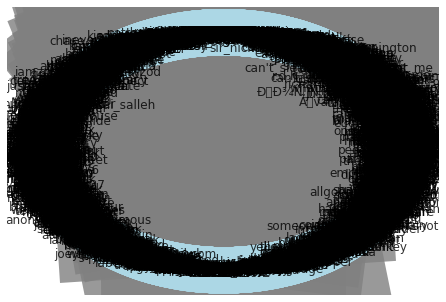

In [86]:
nx.draw_circular(W,width=weights, edge_color="gray", node_color="lightblue", with_labels=True, node_size=2000, font_size=12, font_family="DejaVu Sans",
                alpha=0.8)